# **TP2**

##*Organización de Datos (75.06/95.58) - Primer Cuatrimestre 2021*

###### Julio de 2021
---

In [1]:
# Importamos librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Importamos los archivos de entrada desde google drive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link = 'https://drive.google.com/file/d/1d3bvCoox6nxGIWx81EMEQl_hJ1Y0Jp1q/view?usp=sharing' 
  
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_values.csv')

train_values=pd.read_csv('train_values.csv', index_col='building_id')

In [4]:
link = 'https://drive.google.com/file/d/1zsOf_CScGSl6O2CBbgQUX7TH3CALpXbl/view?usp=sharing' 
  
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_labels.csv')

train_labels=pd.read_csv('train_labels.csv', index_col='building_id')

#Damage grade:
#1 - Low damage
#2 - Medium damage
#3 - Serious damage


In [5]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

#metric
from sklearn.metrics import f1_score

In [6]:
train_values.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [7]:
cat_cols=['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type',
          'position','plan_configuration','legal_ownership_status','geo_level_1_id','geo_level_2_id','geo_level_3_id']
for cc in cat_cols:
    train_values[cc]=train_values[cc].astype('category')

In [8]:
X_dev = train_values

Y_dev = train_labels['damage_grade'].astype('category')

Y_dev


building_id
802906    3
28830     2
94947     3
590882    2
201944    3
         ..
688636    2
669485    3
602512    3
151409    2
747594    3
Name: damage_grade, Length: 260601, dtype: category
Categories (3, int64): [1, 2, 3]

In [9]:
from sklearn.model_selection import train_test_split

seed=2

valsize=0.25
X_train, X_val, Y_train, Y_val = train_test_split(X_dev, Y_dev, test_size=valsize, random_state=seed)

# Sets

## S0: Original

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   count_floors_pre_eq                     195450 non-null  int64   
 4   age                                     195450 non-null  int64   
 5   area_percentage                         195450 non-null  int64   
 6   height_percentage                       195450 non-null  int64   
 7   land_surface_condition                  195450 non-null  category
 8   foundation_type                         195450 non-null  category
 9   roof_type                               195450 non-null  category
 10  ground_floor_type          

##S1

In [11]:
#Numericas
X_train_num=X_train.select_dtypes(exclude='category')
X_train_num=X_train_num[X_train_num.columns.drop(list(X_train_num.filter(like='geo_level')))]
X_train_num=X_train_num[X_train_num.columns.drop(list(X_train_num.filter(like='has_')))]
col1=X_train_num.columns.tolist()

#El resto
col2=X_train.filter(like='type').columns.tolist()
col3=['has_superstructure_mud_mortar_stone','has_superstructure_cement_mortar_brick','has_superstructure_rc_engineered','has_superstructure_rc_non_engineered']
cols=col1+col2+col3+['geo_level_1_id']

In [12]:
X_train_s1 = X_train[cols]
X_val_s1 = X_val[cols]

#Drop count_floors
X_train_s1 = X_train_s1.drop(columns=['count_floors_pre_eq'])
X_val_s1 = X_val_s1.drop(columns=['count_floors_pre_eq'])

X_train_s1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 13 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   age                                     195450 non-null  int64   
 1   area_percentage                         195450 non-null  int64   
 2   height_percentage                       195450 non-null  int64   
 3   count_families                          195450 non-null  int64   
 4   foundation_type                         195450 non-null  category
 5   roof_type                               195450 non-null  category
 6   ground_floor_type                       195450 non-null  category
 7   other_floor_type                        195450 non-null  category
 8   has_superstructure_mud_mortar_stone     195450 non-null  int64   
 9   has_superstructure_cement_mortar_brick  195450 non-null  int64   
 10  has_superstructure_rc_engin

## S2

In [13]:
X_train_s2=X_train.copy()
X_train_s2.drop(columns=['geo_level_2_id','geo_level_3_id','count_floors_pre_eq'],inplace=True)

X_val_s2=X_val.copy()
X_val_s2.drop(columns=['geo_level_2_id','geo_level_3_id','count_floors_pre_eq'],inplace=True)

X_train_s2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 35 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   age                                     195450 non-null  int64   
 2   area_percentage                         195450 non-null  int64   
 3   height_percentage                       195450 non-null  int64   
 4   land_surface_condition                  195450 non-null  category
 5   foundation_type                         195450 non-null  category
 6   roof_type                               195450 non-null  category
 7   ground_floor_type                       195450 non-null  category
 8   other_floor_type                        195450 non-null  category
 9   position                                195450 non-null  category
 10  plan_configuration         

## S3

In [14]:
X_train_s3=X_train.copy()
X_train_s3.drop(columns=['geo_level_2_id','geo_level_3_id'],inplace=True)
X_train_s3['Height_Area']=X_train_s3['height_percentage']/X_train_s3['area_percentage']

X_val_s3=X_val.copy()
X_val_s3.drop(columns=['geo_level_2_id','geo_level_3_id'],inplace=True)
X_val_s3['Height_Area']=X_val_s3['height_percentage']/X_val_s3['area_percentage']

X_train_s3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 37 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   count_floors_pre_eq                     195450 non-null  int64   
 2   age                                     195450 non-null  int64   
 3   area_percentage                         195450 non-null  int64   
 4   height_percentage                       195450 non-null  int64   
 5   land_surface_condition                  195450 non-null  category
 6   foundation_type                         195450 non-null  category
 7   roof_type                               195450 non-null  category
 8   ground_floor_type                       195450 non-null  category
 9   other_floor_type                        195450 non-null  category
 10  position                   

## S4: S3${}_{cb}$

In [15]:
X_train_s4=X_train.copy()
X_train_s4['Height_Area']=X_train_s4['height_percentage']/X_train_s4['area_percentage']

X_val_s4=X_val.copy()
X_val_s4['Height_Area']=X_val_s4['height_percentage']/X_val_s4['area_percentage']

X_train_s4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   count_floors_pre_eq                     195450 non-null  int64   
 4   age                                     195450 non-null  int64   
 5   area_percentage                         195450 non-null  int64   
 6   height_percentage                       195450 non-null  int64   
 7   land_surface_condition                  195450 non-null  category
 8   foundation_type                         195450 non-null  category
 9   roof_type                               195450 non-null  category
 10  ground_floor_type          

## S5: S1${}_{cb}$

In [16]:
cols=col1+col2+col3+['geo_level_1_id','geo_level_2_id','geo_level_3_id']

In [17]:
X_train_s5 = X_train[cols]
X_val_s5 = X_val[cols]

#Drop count_floors 
X_train_s5 = X_train_s5.drop(columns=['count_floors_pre_eq'])
X_val_s5 = X_val_s5.drop(columns=['count_floors_pre_eq'])

X_train_s5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 15 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   age                                     195450 non-null  int64   
 1   area_percentage                         195450 non-null  int64   
 2   height_percentage                       195450 non-null  int64   
 3   count_families                          195450 non-null  int64   
 4   foundation_type                         195450 non-null  category
 5   roof_type                               195450 non-null  category
 6   ground_floor_type                       195450 non-null  category
 7   other_floor_type                        195450 non-null  category
 8   has_superstructure_mud_mortar_stone     195450 non-null  int64   
 9   has_superstructure_cement_mortar_brick  195450 non-null  int64   
 10  has_superstructure_rc_engin

## S6: S0 menos 'count_floors_pre_eq','legal_ownership_status', 'has_secondary_use_'

In [18]:
X_train_s6=X_train.copy()
X_train_s6.drop(columns=['count_floors_pre_eq','legal_ownership_status'],inplace=True)
X_train_s6.drop(columns=X_train_s6.filter(like='has_secondary_use_').columns.tolist(),inplace=True)

X_val_s6=X_val.copy()
X_val_s6.drop(columns=['count_floors_pre_eq','legal_ownership_status'],inplace=True)
X_val_s6.drop(columns=X_val_s6.filter(like='has_secondary_use_').columns.tolist(),inplace=True)

X_train_s6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 26 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   area_percentage                         195450 non-null  int64   
 5   height_percentage                       195450 non-null  int64   
 6   land_surface_condition                  195450 non-null  category
 7   foundation_type                         195450 non-null  category
 8   roof_type                               195450 non-null  category
 9   ground_floor_type                       195450 non-null  category
 10  other_floor_type           

## S7: S6 menos 'plan_configuration'

In [19]:
X_train_s7=X_train_s6.copy()
X_train_s7.drop(columns=['plan_configuration'],inplace=True)

X_val_s7=X_val_s6.copy()
X_val_s7.drop(columns=['plan_configuration'],inplace=True)

X_train_s7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 25 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   area_percentage                         195450 non-null  int64   
 5   height_percentage                       195450 non-null  int64   
 6   land_surface_condition                  195450 non-null  category
 7   foundation_type                         195450 non-null  category
 8   roof_type                               195450 non-null  category
 9   ground_floor_type                       195450 non-null  category
 10  other_floor_type           

## S8: S7 menos has_superstructure_rc_non_engineered, has_superstructure_rc_engineered

In [20]:
X_train_s8=X_train_s7.copy()
X_train_s8.drop(columns=['has_superstructure_rc_non_engineered','has_superstructure_rc_engineered'],inplace=True)

X_val_s8=X_val_s7.copy()
X_val_s8.drop(columns=['has_superstructure_rc_non_engineered','has_superstructure_rc_engineered'],inplace=True)

X_train_s8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 23 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   area_percentage                         195450 non-null  int64   
 5   height_percentage                       195450 non-null  int64   
 6   land_surface_condition                  195450 non-null  category
 7   foundation_type                         195450 non-null  category
 8   roof_type                               195450 non-null  category
 9   ground_floor_type                       195450 non-null  category
 10  other_floor_type           

## S9: S7 mas count_families/area_percentage                         

In [21]:
X_train_s9=X_train_s7.copy()
X_train_s9['families_area']=X_train_s9['count_families']/X_train_s9['area_percentage']

X_val_s9=X_val_s7.copy()
X_val_s9['families_area']=X_val_s9['count_families']/X_val_s9['area_percentage']

X_train_s9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 26 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   area_percentage                         195450 non-null  int64   
 5   height_percentage                       195450 non-null  int64   
 6   land_surface_condition                  195450 non-null  category
 7   foundation_type                         195450 non-null  category
 8   roof_type                               195450 non-null  category
 9   ground_floor_type                       195450 non-null  category
 10  other_floor_type           

## S10: S9 menos count_families

In [22]:
X_train_s10=X_train_s9.copy()
X_train_s10.drop(columns=['count_families'],inplace=True)

X_val_s10=X_val_s9.copy()
X_val_s10.drop(columns=['count_families'],inplace=True)

X_train_s10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 25 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   area_percentage                         195450 non-null  int64   
 5   height_percentage                       195450 non-null  int64   
 6   land_surface_condition                  195450 non-null  category
 7   foundation_type                         195450 non-null  category
 8   roof_type                               195450 non-null  category
 9   ground_floor_type                       195450 non-null  category
 10  other_floor_type           

## S11: S9 menos area

In [23]:
X_train_s11=X_train_s9.copy()
X_train_s11.drop(columns=['area_percentage'],inplace=True)

X_val_s11=X_val_s9.copy()
X_val_s11.drop(columns=['area_percentage'],inplace=True)

X_train_s11.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 25 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   height_percentage                       195450 non-null  int64   
 5   land_surface_condition                  195450 non-null  category
 6   foundation_type                         195450 non-null  category
 7   roof_type                               195450 non-null  category
 8   ground_floor_type                       195450 non-null  category
 9   other_floor_type                        195450 non-null  category
 10  position                   

## S12: S9 menos area y families

In [24]:
X_train_s12=X_train_s9.copy()
X_train_s12.drop(columns=['area_percentage','count_families'],inplace=True)

X_val_s12=X_val_s9.copy()
X_val_s12.drop(columns=['area_percentage','count_families'],inplace=True)

X_train_s12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 24 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   height_percentage                       195450 non-null  int64   
 5   land_surface_condition                  195450 non-null  category
 6   foundation_type                         195450 non-null  category
 7   roof_type                               195450 non-null  category
 8   ground_floor_type                       195450 non-null  category
 9   other_floor_type                        195450 non-null  category
 10  position                   

## S13: S7 mas count_floor/area_percentage                         

In [25]:
X_train_s13=X_train_s7.copy()
X_train_s13['count_floors_pre_eq']=X_train['count_floors_pre_eq']
X_train_s13['floor_area']=X_train_s13['count_floors_pre_eq']/X_train_s13['area_percentage']

X_val_s13=X_val_s7.copy()
X_val_s13['count_floors_pre_eq']=X_val['count_floors_pre_eq']
X_val_s13['floor_area']=X_val_s13['count_floors_pre_eq']/X_val_s13['area_percentage']

X_train_s13.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 27 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   area_percentage                         195450 non-null  int64   
 5   height_percentage                       195450 non-null  int64   
 6   land_surface_condition                  195450 non-null  category
 7   foundation_type                         195450 non-null  category
 8   roof_type                               195450 non-null  category
 9   ground_floor_type                       195450 non-null  category
 10  other_floor_type           

## S14: S13 menos count_floor

In [26]:
X_train_s14=X_train_s13.copy()
X_train_s14.drop(columns=['count_floors_pre_eq'],inplace=True)

X_val_s14=X_val_s13.copy()
X_val_s14.drop(columns=['count_floors_pre_eq'],inplace=True)

X_train_s14.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 26 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   area_percentage                         195450 non-null  int64   
 5   height_percentage                       195450 non-null  int64   
 6   land_surface_condition                  195450 non-null  category
 7   foundation_type                         195450 non-null  category
 8   roof_type                               195450 non-null  category
 9   ground_floor_type                       195450 non-null  category
 10  other_floor_type           

## S15: S13 menos area

In [27]:
X_train_s15=X_train_s13.copy()
X_train_s15.drop(columns=['area_percentage'],inplace=True)

X_val_s15=X_val_s13.copy()
X_val_s15.drop(columns=['area_percentage'],inplace=True)

X_train_s15.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 26 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   height_percentage                       195450 non-null  int64   
 5   land_surface_condition                  195450 non-null  category
 6   foundation_type                         195450 non-null  category
 7   roof_type                               195450 non-null  category
 8   ground_floor_type                       195450 non-null  category
 9   other_floor_type                        195450 non-null  category
 10  position                   

## S16: S13 menos area y floors

In [28]:
X_train_s16=X_train_s13.copy()
X_train_s16.drop(columns=['area_percentage','count_floors_pre_eq'],inplace=True)

X_val_s16=X_val_s13.copy()
X_val_s16.drop(columns=['area_percentage','count_floors_pre_eq'],inplace=True)

X_train_s16.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 25 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   height_percentage                       195450 non-null  int64   
 5   land_surface_condition                  195450 non-null  category
 6   foundation_type                         195450 non-null  category
 7   roof_type                               195450 non-null  category
 8   ground_floor_type                       195450 non-null  category
 9   other_floor_type                        195450 non-null  category
 10  position                   

## S17: S7 mas height/area

In [29]:
X_train_s17=X_train_s7.copy()
X_train_s17['height_area']=X_train_s17['height_percentage']/X_train_s17['area_percentage']

X_val_s17=X_val_s7.copy()
X_val_s17['height_area']=X_val_s17['height_percentage']/X_val_s17['area_percentage']

X_train_s17.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 26 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   area_percentage                         195450 non-null  int64   
 5   height_percentage                       195450 non-null  int64   
 6   land_surface_condition                  195450 non-null  category
 7   foundation_type                         195450 non-null  category
 8   roof_type                               195450 non-null  category
 9   ground_floor_type                       195450 non-null  category
 10  other_floor_type           

## S18: S17 menos area_percentage

In [30]:
X_train_s18=X_train_s17.copy()
X_train_s18.drop(columns=['area_percentage'],inplace=True)

X_val_s18=X_val_s17.copy()
X_val_s18.drop(columns=['area_percentage'],inplace=True)

X_train_s18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 25 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   height_percentage                       195450 non-null  int64   
 5   land_surface_condition                  195450 non-null  category
 6   foundation_type                         195450 non-null  category
 7   roof_type                               195450 non-null  category
 8   ground_floor_type                       195450 non-null  category
 9   other_floor_type                        195450 non-null  category
 10  position                   

## S19: S17 menos height_percentage

In [31]:
X_train_s19=X_train_s17.copy()
X_train_s19.drop(columns=['height_percentage'],inplace=True)

X_val_s19=X_val_s17.copy()
X_val_s19.drop(columns=['height_percentage'],inplace=True)

X_train_s19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 25 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   area_percentage                         195450 non-null  int64   
 5   land_surface_condition                  195450 non-null  category
 6   foundation_type                         195450 non-null  category
 7   roof_type                               195450 non-null  category
 8   ground_floor_type                       195450 non-null  category
 9   other_floor_type                        195450 non-null  category
 10  position                   

## S20: S17 menos area y height

In [32]:
X_train_s20=X_train_s17.copy()
X_train_s20.drop(columns=['area_percentage','height_percentage'],inplace=True)

X_val_s20=X_val_s17.copy()
X_val_s20.drop(columns=['area_percentage','height_percentage'],inplace=True)

X_train_s20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 24 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   land_surface_condition                  195450 non-null  category
 5   foundation_type                         195450 non-null  category
 6   roof_type                               195450 non-null  category
 7   ground_floor_type                       195450 non-null  category
 8   other_floor_type                        195450 non-null  category
 9   position                                195450 non-null  category
 10  has_superstructure_adobe_mu

## S21: S0 mas count_floor/area_percentage                         

In [33]:
X_train_s21=X_train.copy()
X_train_s21['floor_area']=X_train['count_floors_pre_eq']/X_train['area_percentage']

X_val_s21=X_val.copy()
X_val_s21['floor_area']=X_val['count_floors_pre_eq']/X_val['area_percentage']

X_train_s21.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   count_floors_pre_eq                     195450 non-null  int64   
 4   age                                     195450 non-null  int64   
 5   area_percentage                         195450 non-null  int64   
 6   height_percentage                       195450 non-null  int64   
 7   land_surface_condition                  195450 non-null  category
 8   foundation_type                         195450 non-null  category
 9   roof_type                               195450 non-null  category
 10  ground_floor_type          

## S22: S0 menos 'legal_ownership_status', 'has_secondary_use_'

In [34]:
X_train_s22=X_train.copy()
X_train_s22.drop(columns=['legal_ownership_status'],inplace=True)
X_train_s22.drop(columns=X_train_s22.filter(like='has_secondary_use_').columns.tolist(),inplace=True)

X_val_s22=X_val.copy()
X_val_s22.drop(columns=['legal_ownership_status'],inplace=True)
X_val_s22.drop(columns=X_val_s22.filter(like='has_secondary_use_').columns.tolist(),inplace=True)

X_train_s22.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 27 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   count_floors_pre_eq                     195450 non-null  int64   
 4   age                                     195450 non-null  int64   
 5   area_percentage                         195450 non-null  int64   
 6   height_percentage                       195450 non-null  int64   
 7   land_surface_condition                  195450 non-null  category
 8   foundation_type                         195450 non-null  category
 9   roof_type                               195450 non-null  category
 10  ground_floor_type          

# Modelo: CatBoost

In [35]:
!pip install catboost
from catboost import CatBoostClassifier,Pool

     |████████████████████████████████| 69.2 MB 5.2 kB/s 


##S0

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   count_floors_pre_eq                     195450 non-null  int64   
 4   age                                     195450 non-null  int64   
 5   area_percentage                         195450 non-null  int64   
 6   height_percentage                       195450 non-null  int64   
 7   land_surface_condition                  195450 non-null  category
 8   foundation_type                         195450 non-null  category
 9   roof_type                               195450 non-null  category
 10  ground_floor_type          

In [ ]:
model = CatBoostClassifier(cat_features=X_train.select_dtypes('category').columns, logging_level='Silent')
model.fit(X_train,Y_train)

In [ ]:
y_pred = model.predict(X_val)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.7473100950100535


[8.01229577e+00 2.85966701e+01 1.58843214e+01 8.53382809e-01
 7.55401741e+00 3.11693476e+00 1.30812211e+00 1.81300799e+00
 7.10657792e+00 3.61042359e+00 3.66573366e+00 5.20573660e+00
 2.17772933e+00 6.72401539e-01 2.93550129e-01 1.78687700e+00
 2.54489291e-01 2.95160277e-01 7.19972836e-01 1.17837899e+00
 6.53279035e-01 2.87029444e-01 1.44136035e-01 1.49837345e-01
 2.05852886e-01 1.03403887e+00 1.96558436e+00 9.51883113e-01
 2.64038407e-01 5.05508377e-02 6.37083275e-02 4.41730046e-03
 1.18157173e-03 9.99417434e-03 0.00000000e+00 8.40600948e-03
 3.61552079e-02 6.41236013e-02]


Text(0.5, 1.0, 'CatBoost: set S0')

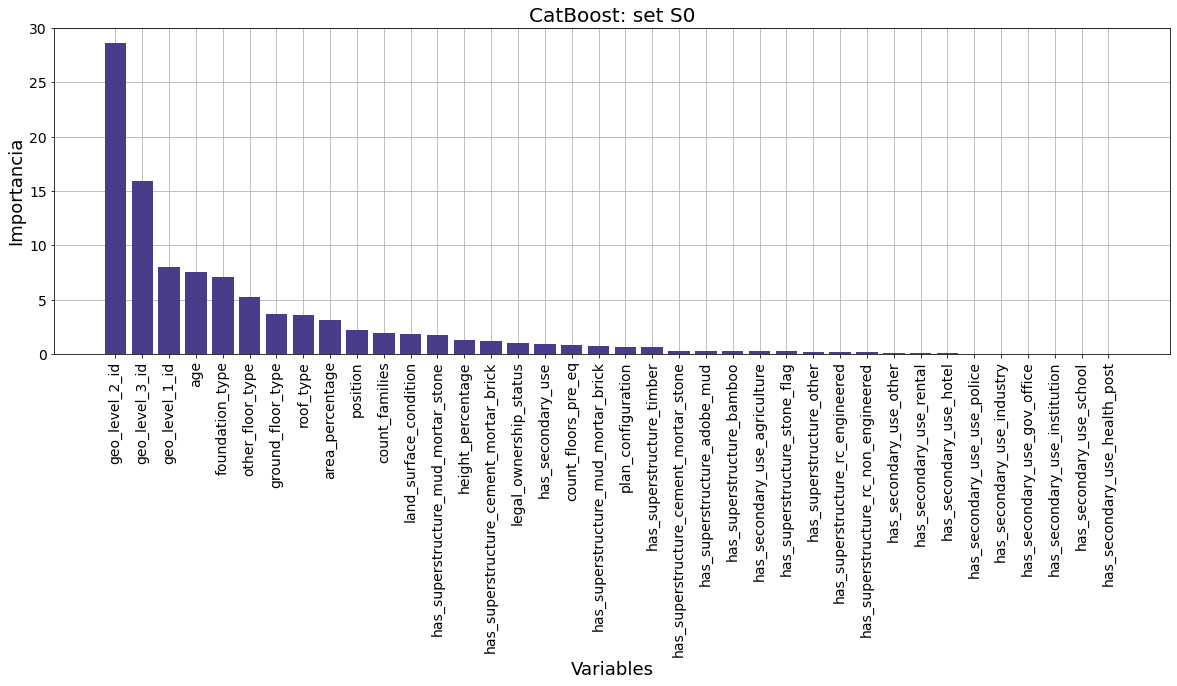

In [ ]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S0',fontsize=20)

## S1

In [ ]:
X_train_s1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 13 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   age                                     195450 non-null  int64   
 1   area_percentage                         195450 non-null  int64   
 2   height_percentage                       195450 non-null  int64   
 3   count_families                          195450 non-null  int64   
 4   foundation_type                         195450 non-null  category
 5   roof_type                               195450 non-null  category
 6   ground_floor_type                       195450 non-null  category
 7   other_floor_type                        195450 non-null  category
 8   has_superstructure_mud_mortar_stone     195450 non-null  int64   
 9   has_superstructure_cement_mortar_brick  195450 non-null  int64   
 10  has_superstructure_rc_engin

In [ ]:
model = CatBoostClassifier(cat_features=X_train_s1.select_dtypes('category').columns, logging_level='Silent')
model.fit(X_train_s1,Y_train)

In [ ]:
y_pred = model.predict(X_val_s1)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.6862979846817393


## S2

In [ ]:
X_train_s2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 35 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   age                                     195450 non-null  int64   
 2   area_percentage                         195450 non-null  int64   
 3   height_percentage                       195450 non-null  int64   
 4   land_surface_condition                  195450 non-null  category
 5   foundation_type                         195450 non-null  category
 6   roof_type                               195450 non-null  category
 7   ground_floor_type                       195450 non-null  category
 8   other_floor_type                        195450 non-null  category
 9   position                                195450 non-null  category
 10  plan_configuration         

In [ ]:
model = CatBoostClassifier(cat_features=X_train_s2.select_dtypes('category').columns, logging_level='Silent')
model.fit(X_train_s2,Y_train)

In [ ]:
y_pred = model.predict(X_val_s2)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.6943408389740756


## S3

In [ ]:
X_train_s3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 37 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   count_floors_pre_eq                     195450 non-null  int64   
 2   age                                     195450 non-null  int64   
 3   area_percentage                         195450 non-null  int64   
 4   height_percentage                       195450 non-null  int64   
 5   land_surface_condition                  195450 non-null  category
 6   foundation_type                         195450 non-null  category
 7   roof_type                               195450 non-null  category
 8   ground_floor_type                       195450 non-null  category
 9   other_floor_type                        195450 non-null  category
 10  position                   

In [ ]:
model = CatBoostClassifier(cat_features=X_train_s3.select_dtypes('category').columns, logging_level='Silent')
model.fit(X_train_s3,Y_train)

In [ ]:
y_pred = model.predict(X_val_s3)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.6940492087611856


## S4

In [ ]:
X_train_s4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   count_floors_pre_eq                     195450 non-null  int64   
 4   age                                     195450 non-null  int64   
 5   area_percentage                         195450 non-null  int64   
 6   height_percentage                       195450 non-null  int64   
 7   land_surface_condition                  195450 non-null  category
 8   foundation_type                         195450 non-null  category
 9   roof_type                               195450 non-null  category
 10  ground_floor_type          

In [ ]:
model = CatBoostClassifier(cat_features=X_train_s4.select_dtypes('category').columns, logging_level='Silent')
model.fit(X_train_s4,Y_train)

In [ ]:
y_pred = model.predict(X_val_s4)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.7459593866556155


[8.08353369e+00 2.39488919e+01 1.98875803e+01 9.86471695e-01
 7.72063238e+00 2.48297544e+00 1.25800161e+00 1.69115692e+00
 7.31814401e+00 3.89837027e+00 3.51253774e+00 5.24717640e+00
 2.04329696e+00 7.94571586e-01 2.69618053e-01 1.69197063e+00
 2.42147943e-01 3.20201749e-01 7.24730426e-01 1.08254812e+00
 6.63799186e-01 2.30739215e-01 7.24566579e-02 1.38864727e-01
 2.10537998e-01 8.10732220e-01 1.88985236e+00 6.70480524e-01
 1.85726838e-01 3.50798865e-02 4.82882830e-02 7.12242273e-03
 5.56596887e-03 2.70161668e-02 0.00000000e+00 1.13615685e-02
 2.19929629e-02 3.28007102e-02 1.73302452e+00]


Text(0.5, 1.0, 'CatBoost: set S4')

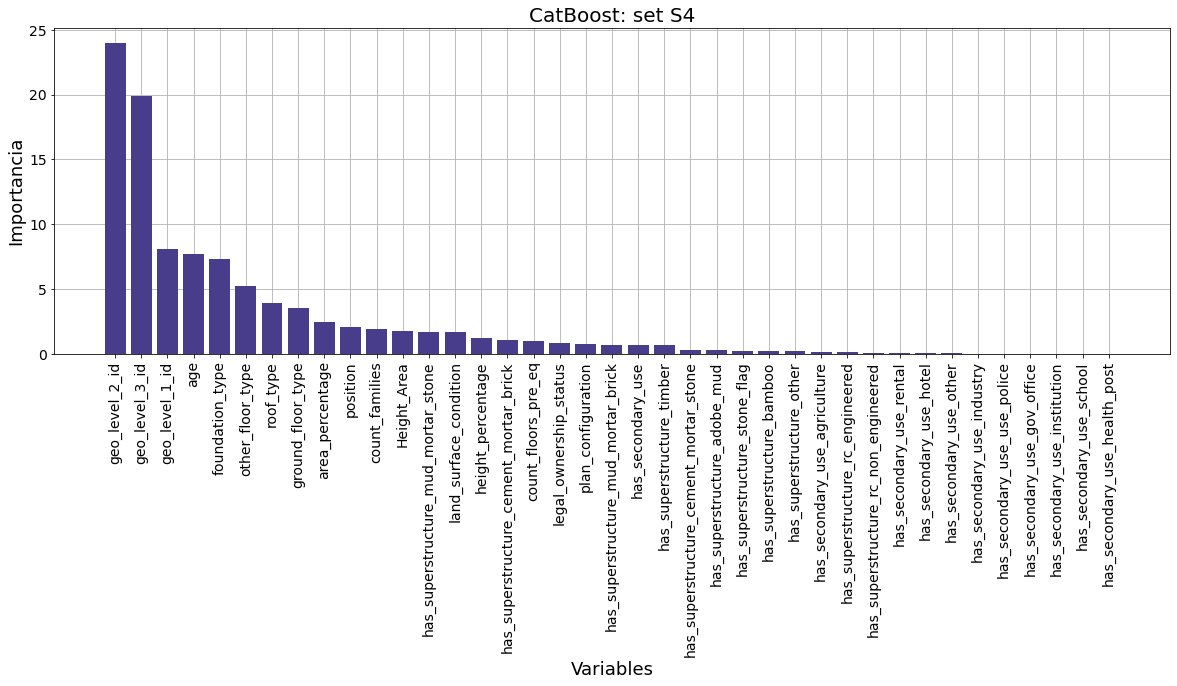

In [ ]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s4.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S4',fontsize=20)

## S5

In [ ]:
X_train_s5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 15 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   age                                     195450 non-null  int64   
 1   area_percentage                         195450 non-null  int64   
 2   height_percentage                       195450 non-null  int64   
 3   count_families                          195450 non-null  int64   
 4   foundation_type                         195450 non-null  category
 5   roof_type                               195450 non-null  category
 6   ground_floor_type                       195450 non-null  category
 7   other_floor_type                        195450 non-null  category
 8   has_superstructure_mud_mortar_stone     195450 non-null  int64   
 9   has_superstructure_cement_mortar_brick  195450 non-null  int64   
 10  has_superstructure_rc_engin

In [ ]:
model = CatBoostClassifier(cat_features=X_train_s5.select_dtypes('category').columns, logging_level='Silent')
model.fit(X_train_s5,Y_train)

In [ ]:
y_pred = model.predict(X_val_s5)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.7453761262298353


[ 8.2952828   3.29259442  2.45142875  2.23493769  8.05460535  5.01402146
  4.56246695  6.10081375  1.98065388  1.16645118  0.1939108   0.15134214
  8.92379838 26.85908974 20.71860273]


Text(0.5, 1.0, 'CatBoost: set S5')

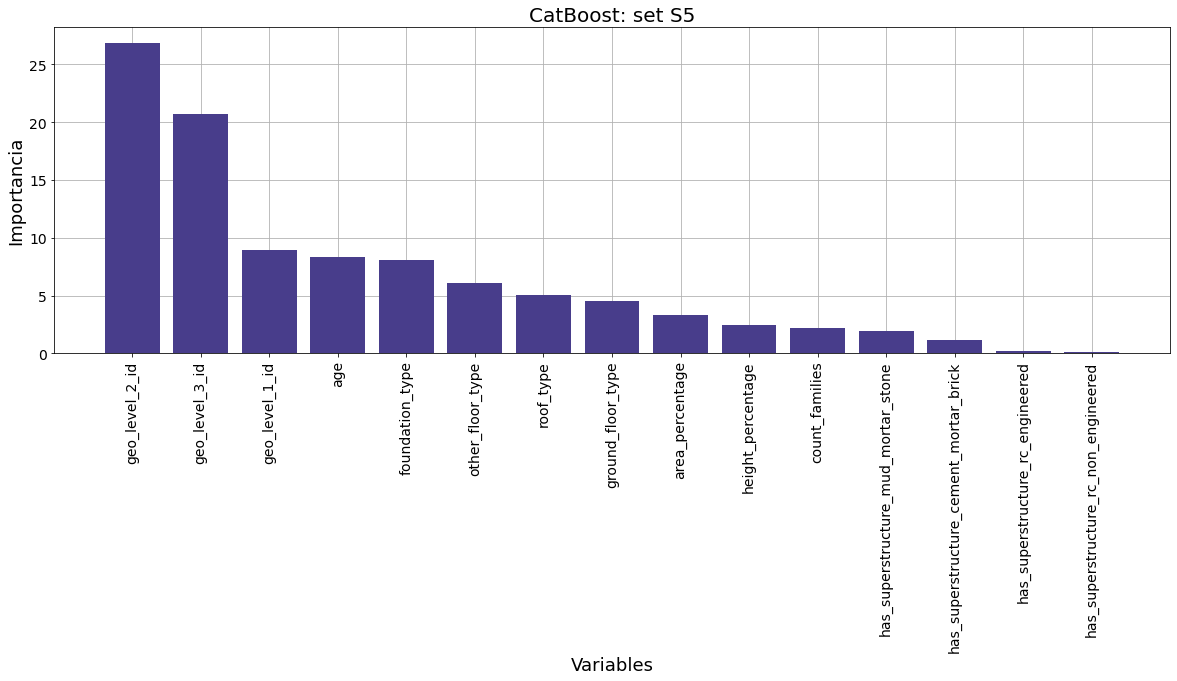

In [ ]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s5.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S5',fontsize=20)

## S6

In [ ]:
X_train_s6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 26 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   area_percentage                         195450 non-null  int64   
 5   height_percentage                       195450 non-null  int64   
 6   land_surface_condition                  195450 non-null  category
 7   foundation_type                         195450 non-null  category
 8   roof_type                               195450 non-null  category
 9   ground_floor_type                       195450 non-null  category
 10  other_floor_type           

In [ ]:
model = CatBoostClassifier(cat_features=X_train_s6.select_dtypes('category').columns, logging_level='Silent')
model.fit(X_train_s6,Y_train)

In [ ]:
y_pred = model.predict(X_val_s6)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.7474942825129315


[ 8.06187716 24.79427231 20.26652009  7.35197499  2.99137076  1.61621772
  1.75398407  7.07255483  3.87950171  4.36510894  5.99595156  2.12179548
  0.85955874  0.38493786  2.05413518  0.29739018  0.31808182  0.62463301
  1.07075486  0.64068101  0.32671203  0.14545968  0.11082421  0.21074826
  1.76450318  0.92045038]


Text(0.5, 1.0, 'CatBoost: set S6')

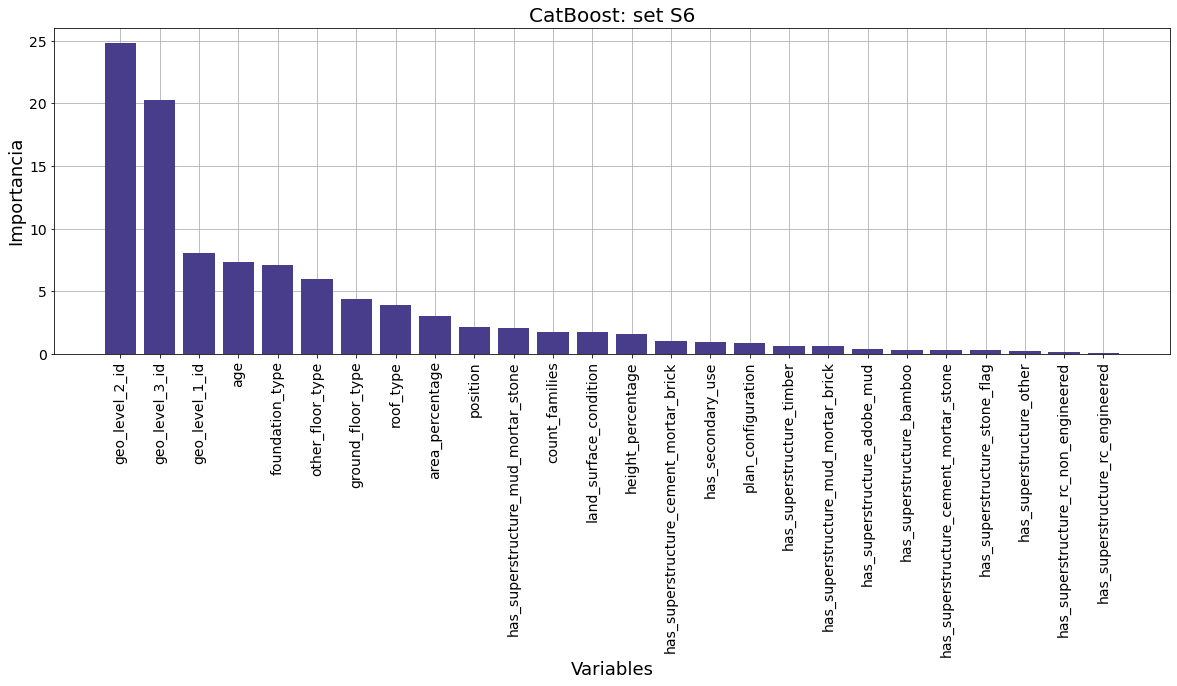

In [ ]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s6.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S6',fontsize=20)

## S7

In [ ]:
X_train_s7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 25 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   area_percentage                         195450 non-null  int64   
 5   height_percentage                       195450 non-null  int64   
 6   land_surface_condition                  195450 non-null  category
 7   foundation_type                         195450 non-null  category
 8   roof_type                               195450 non-null  category
 9   ground_floor_type                       195450 non-null  category
 10  other_floor_type           

In [ ]:
model = CatBoostClassifier(cat_features=X_train_s7.select_dtypes('category').columns, logging_level='Silent')
model.fit(X_train_s7,Y_train)

In [ ]:
y_pred = model.predict(X_val_s7)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.7477705637672484


[ 8.25086961 24.96516477 20.4474662   7.66775686  2.95731896  1.86369462
  2.26415182  6.75689649  3.34539132  3.23297517  6.0835244   2.50490276
  0.5130885   2.06037422  0.34612238  0.32631689  0.94328725  1.24378213
  0.62884     0.30083092  0.14041355  0.12246408  0.25529917  1.87441318
  0.90465476]


Text(0.5, 1.0, 'CatBoost: set S7')

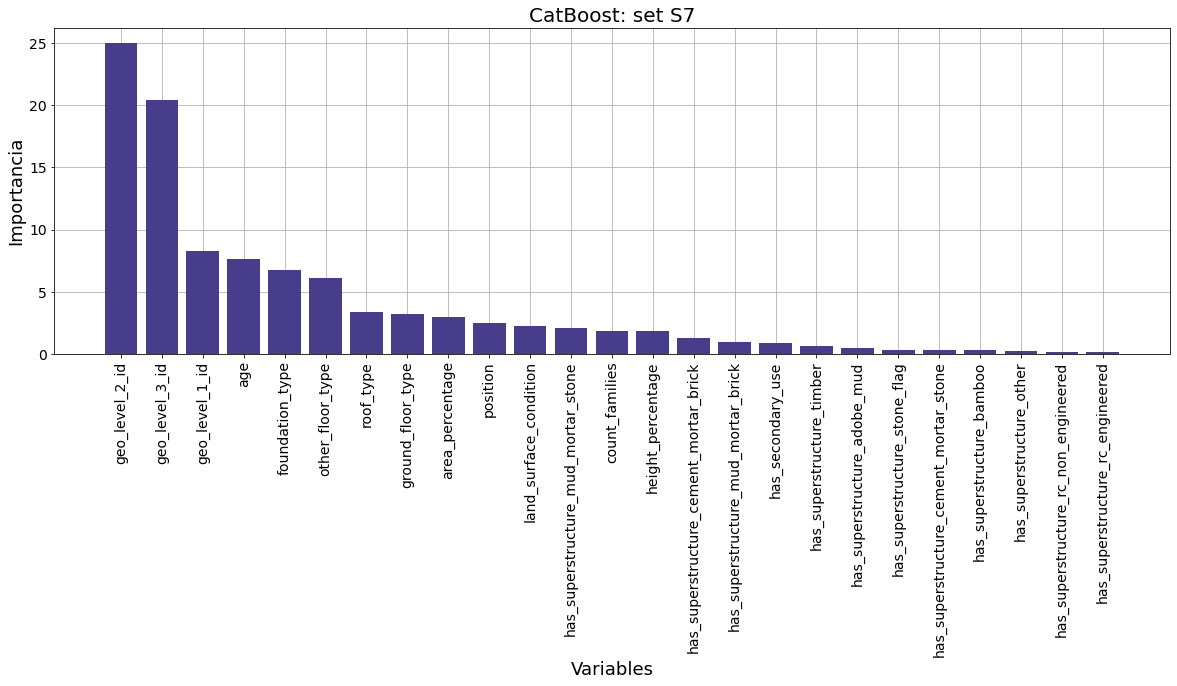

In [ ]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s7.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S7',fontsize=20)

## S8

In [ ]:
X_train_s8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 23 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   area_percentage                         195450 non-null  int64   
 5   height_percentage                       195450 non-null  int64   
 6   land_surface_condition                  195450 non-null  category
 7   foundation_type                         195450 non-null  category
 8   roof_type                               195450 non-null  category
 9   ground_floor_type                       195450 non-null  category
 10  other_floor_type           

In [ ]:
model = CatBoostClassifier(cat_features=X_train_s8.select_dtypes('category').columns, logging_level='Silent')
model.fit(X_train_s8,Y_train)

In [ ]:
y_pred = model.predict(X_val_s8)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.7469570689628708


[ 8.44811586 28.09363417 17.27006352  8.27138263  3.14169357  1.86517227
  2.04363409  6.82221305  2.68204181  4.07368581  5.93437343  2.45071522
  0.52912972  2.12271411  0.22476929  0.24290279  0.74655766  1.12343285
  0.71849937  0.27611393  0.24812191  1.73641349  0.93461945]


Text(0.5, 1.0, 'CatBoost: set S8')

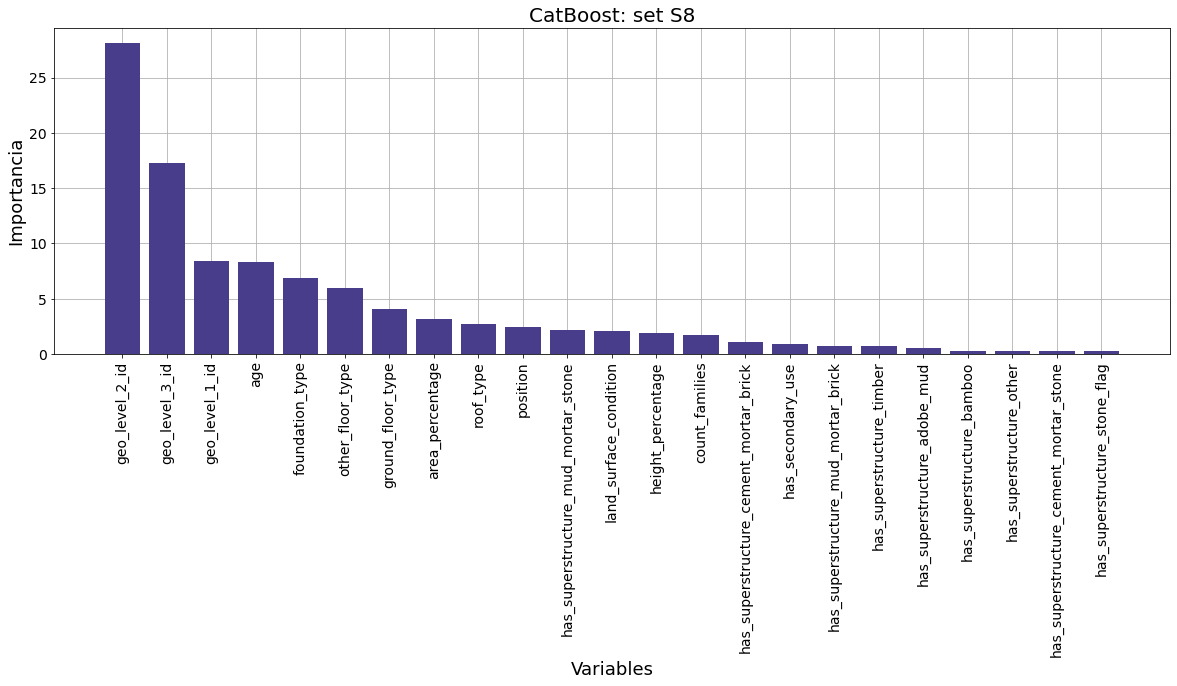

In [ ]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s8.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S8',fontsize=20)

## S9

In [36]:
X_train_s9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 26 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   area_percentage                         195450 non-null  int64   
 5   height_percentage                       195450 non-null  int64   
 6   land_surface_condition                  195450 non-null  category
 7   foundation_type                         195450 non-null  category
 8   roof_type                               195450 non-null  category
 9   ground_floor_type                       195450 non-null  category
 10  other_floor_type           

In [37]:
model = CatBoostClassifier(cat_features=X_train_s9.select_dtypes('category').columns, random_state=2, logging_level='Silent')
model.fit(X_train_s9,Y_train)

In [38]:
y_pred = model.predict(X_val_s9)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.746972417921444


[ 8.09303794 26.45149399 19.03335921  7.98817345  2.75622262  1.75975168
  1.93950907  7.39989153  3.46070304  3.99379483  5.29162776  1.67751962
  0.54506     1.65714148  0.279672    0.33411465  0.67664097  1.13219796
  0.65247387  0.28917052  0.131753    0.14092471  0.22822608  0.79160371
  1.10015559  2.19578071]


Text(0.5, 1.0, 'CatBoost: set S9')

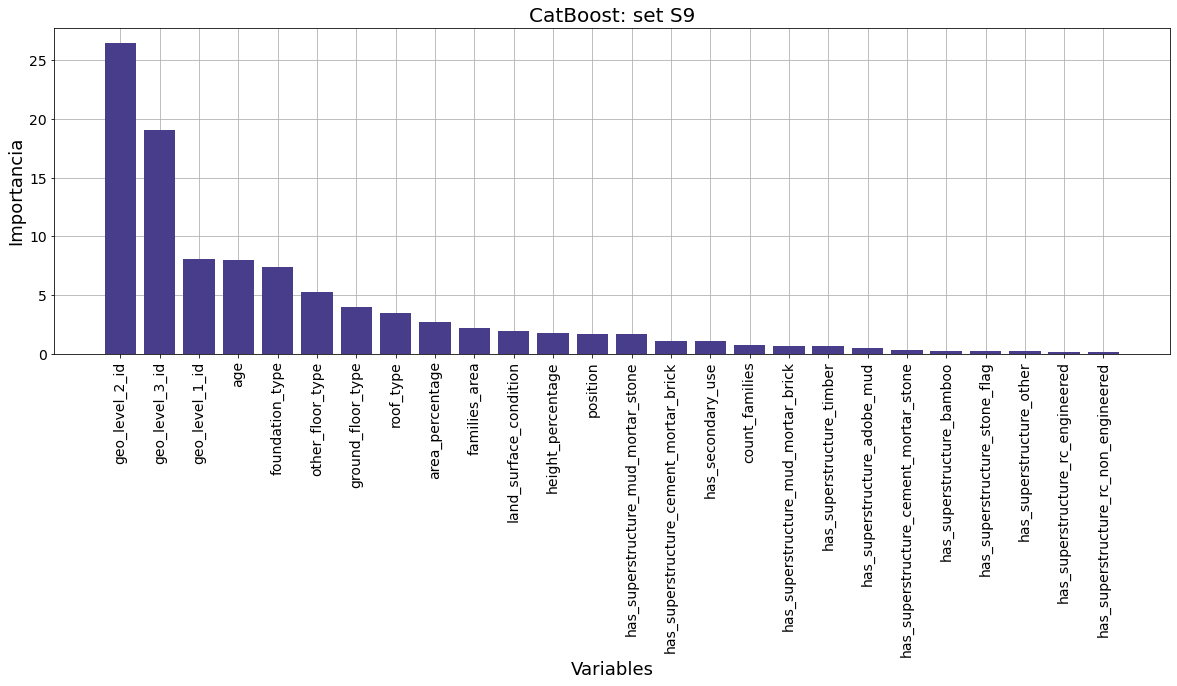

In [39]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s9.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S9',fontsize=20)

## S10

In [40]:
X_train_s10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 25 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   area_percentage                         195450 non-null  int64   
 5   height_percentage                       195450 non-null  int64   
 6   land_surface_condition                  195450 non-null  category
 7   foundation_type                         195450 non-null  category
 8   roof_type                               195450 non-null  category
 9   ground_floor_type                       195450 non-null  category
 10  other_floor_type           

In [41]:
model = CatBoostClassifier(cat_features=X_train_s10.select_dtypes('category').columns, random_state=2, logging_level='Silent')
model.fit(X_train_s10,Y_train)

In [42]:
y_pred = model.predict(X_val_s10)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.7473100950100535


[ 8.03136664 24.23229003 20.25770453  7.80208083  3.08319294  1.97764472
  1.86997251  6.90620884  4.14104267  4.16083177  5.30484544  2.30649695
  0.49532187  1.90754937  0.33142378  0.3199288   0.77132635  1.14048528
  0.69774259  0.27149697  0.08673986  0.17118498  0.19579999  0.89889457
  2.63842774]


Text(0.5, 1.0, 'CatBoost: set S10')

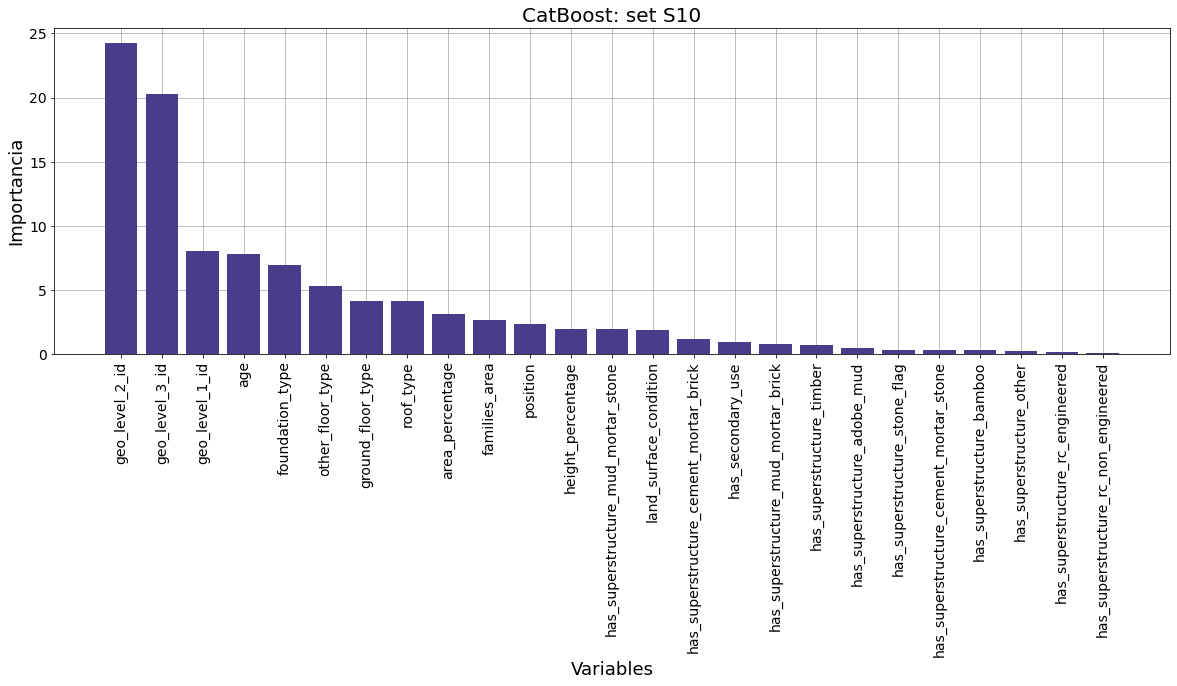

In [43]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s10.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S10',fontsize=20)

## S11

In [56]:
X_train_s11.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 25 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   height_percentage                       195450 non-null  int64   
 5   land_surface_condition                  195450 non-null  category
 6   foundation_type                         195450 non-null  category
 7   roof_type                               195450 non-null  category
 8   ground_floor_type                       195450 non-null  category
 9   other_floor_type                        195450 non-null  category
 10  position                   

In [57]:
model = CatBoostClassifier(cat_features=X_train_s11.select_dtypes('category').columns, random_state=2, logging_level='Silent')
model.fit(X_train_s11,Y_train)

In [58]:
y_pred = model.predict(X_val_s11)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.7466040429156882


[ 8.01963384 24.38271509 19.94993659  7.64644042  1.91752431  1.79602633
  6.94641936  4.36805153  4.62164149  5.45835359  2.59501351  0.48940304
  1.97123105  0.22780537  0.54029821  0.7496519   1.06227131  0.7649501
  0.29328345  0.13596057  0.1466817   0.22282654  0.94689578  0.82303506
  3.92394985]


Text(0.5, 1.0, 'CatBoost: set S11')

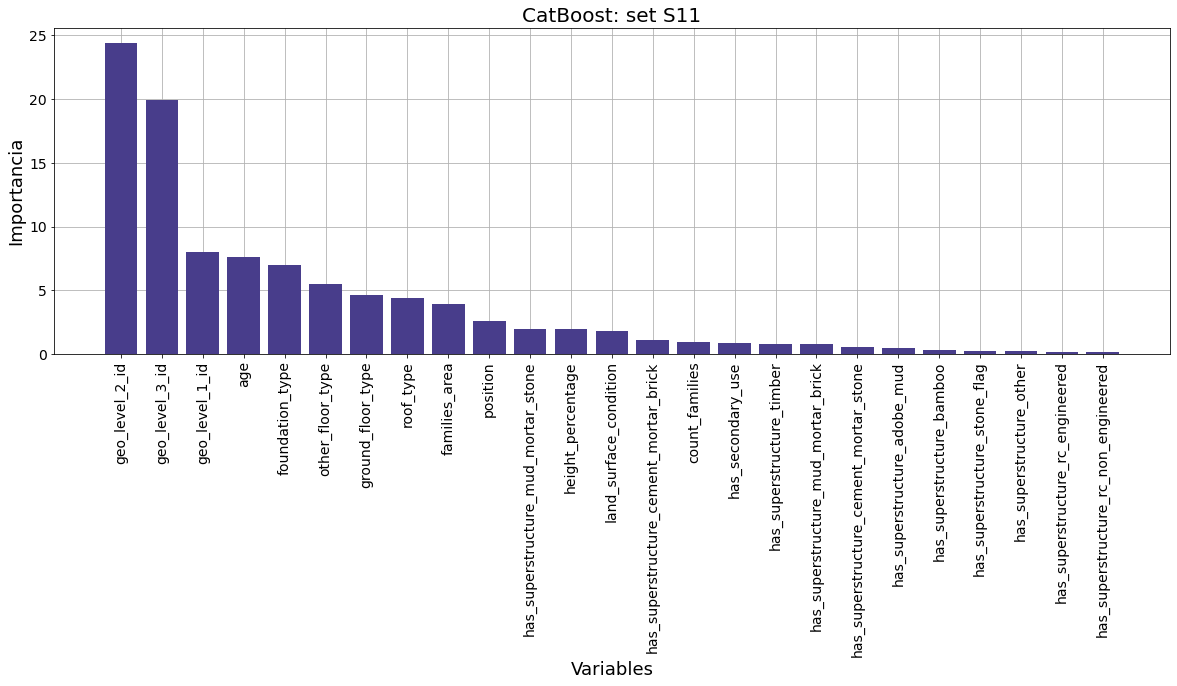

In [59]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s11.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S11',fontsize=20)

## S12

In [46]:
X_train_s12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 24 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   height_percentage                       195450 non-null  int64   
 5   land_surface_condition                  195450 non-null  category
 6   foundation_type                         195450 non-null  category
 7   roof_type                               195450 non-null  category
 8   ground_floor_type                       195450 non-null  category
 9   other_floor_type                        195450 non-null  category
 10  position                   

In [47]:
model = CatBoostClassifier(cat_features=X_train_s12.select_dtypes('category').columns, random_state=2, logging_level='Silent')
model.fit(X_train_s12,Y_train)

In [48]:
y_pred = model.predict(X_val_s12)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.7469110220871514


[ 8.25406115 25.82237041 18.64603653  7.84159996  2.02738732  2.10850642
  5.9218231   4.16912539  5.46222004  5.42307445  2.65890741  0.6881735
  1.92571205  0.3104238   0.38145867  0.81709595  1.06243828  0.63573623
  0.26568409  0.10064491  0.16465683  0.17864102  0.74440623  4.38981627]


Text(0.5, 1.0, 'CatBoost: set S12')

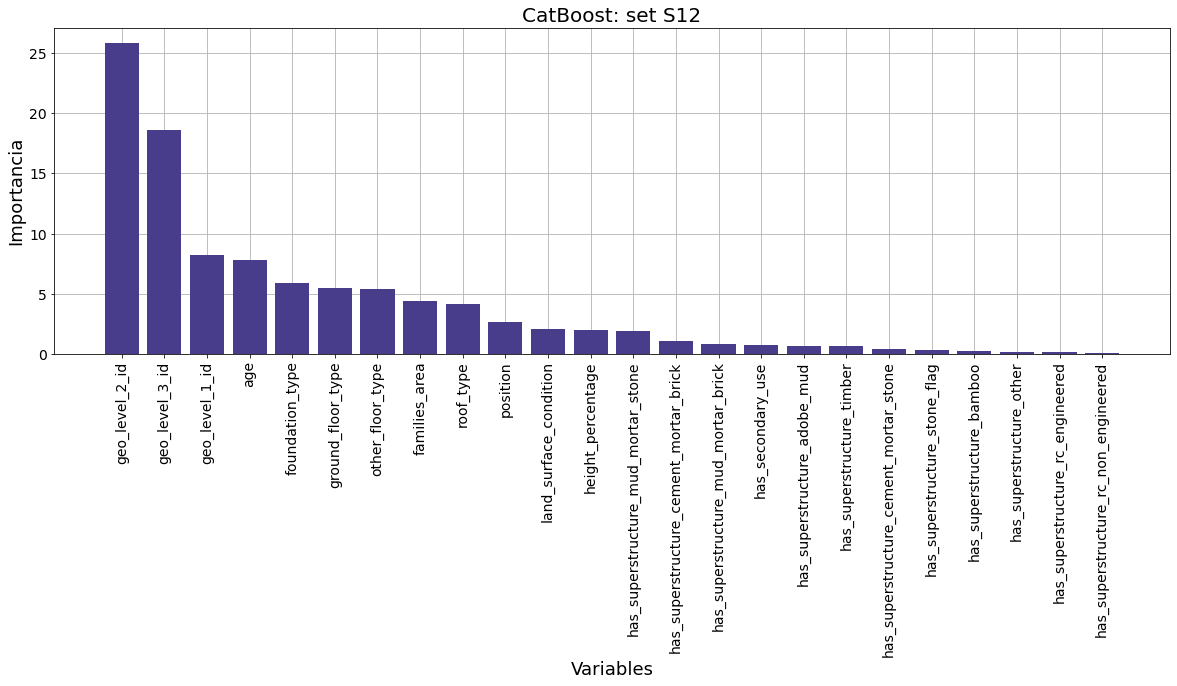

In [49]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s12.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S12',fontsize=20)

## S13

In [50]:
X_train_s13.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 27 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   area_percentage                         195450 non-null  int64   
 5   height_percentage                       195450 non-null  int64   
 6   land_surface_condition                  195450 non-null  category
 7   foundation_type                         195450 non-null  category
 8   roof_type                               195450 non-null  category
 9   ground_floor_type                       195450 non-null  category
 10  other_floor_type           

In [51]:
model = CatBoostClassifier(cat_features=X_train_s13.select_dtypes('category').columns, random_state=2, logging_level='Silent')
model.fit(X_train_s13,Y_train)

In [52]:
y_pred = model.predict(X_val_s13)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.7482617304415895


[ 7.99139423 24.82707354 18.97801398  8.04969689  2.49329158  1.27367689
  1.55852661  6.90152411  4.14660344  4.41258913  5.33784636  2.24411594
  0.4465859   1.86082832  0.27412054  0.30921858  0.78487283  1.09169499
  0.71161563  0.27476446  0.0954335   0.14874814  0.17196203  1.75736832
  0.87182216  1.1197257   1.86688621]


Text(0.5, 1.0, 'CatBoost: set S13')

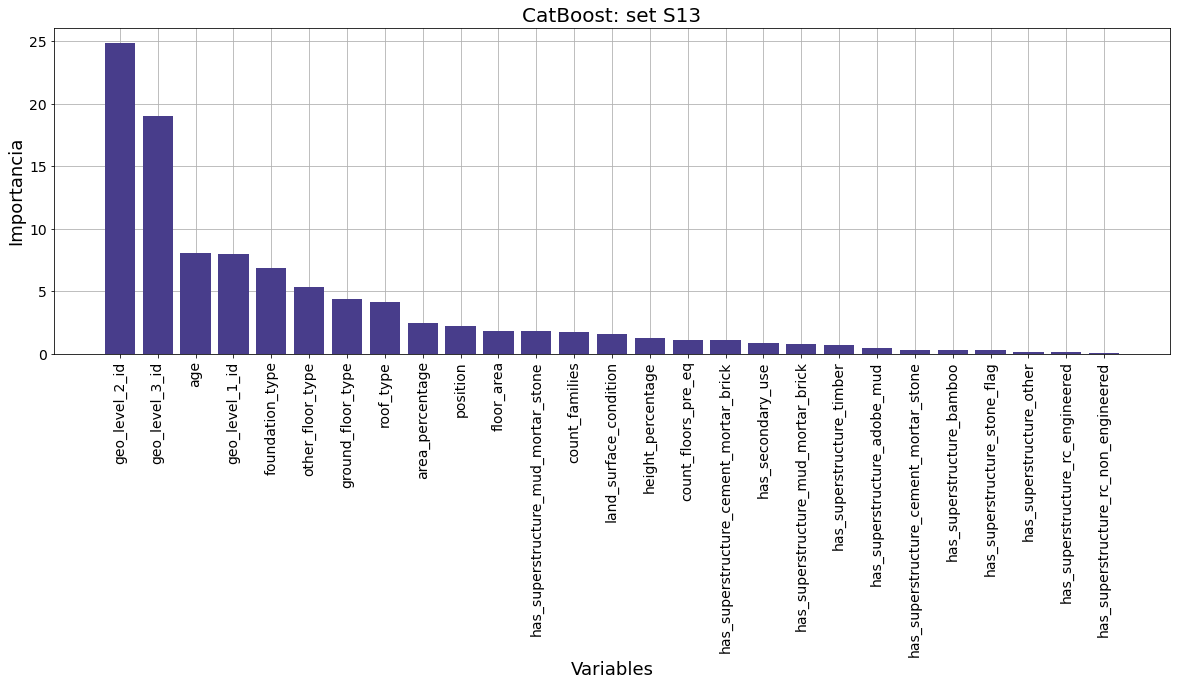

In [53]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s13.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S13',fontsize=20)

## S14

In [60]:
X_train_s14.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 26 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   area_percentage                         195450 non-null  int64   
 5   height_percentage                       195450 non-null  int64   
 6   land_surface_condition                  195450 non-null  category
 7   foundation_type                         195450 non-null  category
 8   roof_type                               195450 non-null  category
 9   ground_floor_type                       195450 non-null  category
 10  other_floor_type           

In [61]:
model = CatBoostClassifier(cat_features=X_train_s14.select_dtypes('category').columns, random_state=2, logging_level='Silent')
model.fit(X_train_s14,Y_train)

In [62]:
y_pred = model.predict(X_val_s14)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.7465426470813956


[ 7.85143812 25.60275897 18.71633884  7.94141864  3.09468232  1.64682912
  1.63358108  7.87076058  3.29638416  4.17942378  5.64474932  1.90720798
  0.42255163  1.71048273  0.26168776  0.36762362  0.69037091  1.05485036
  0.65561558  0.30433497  0.13956972  0.14108297  0.25097737  1.80571862
  0.83947731  1.97008353]


Text(0.5, 1.0, 'CatBoost: set S14')

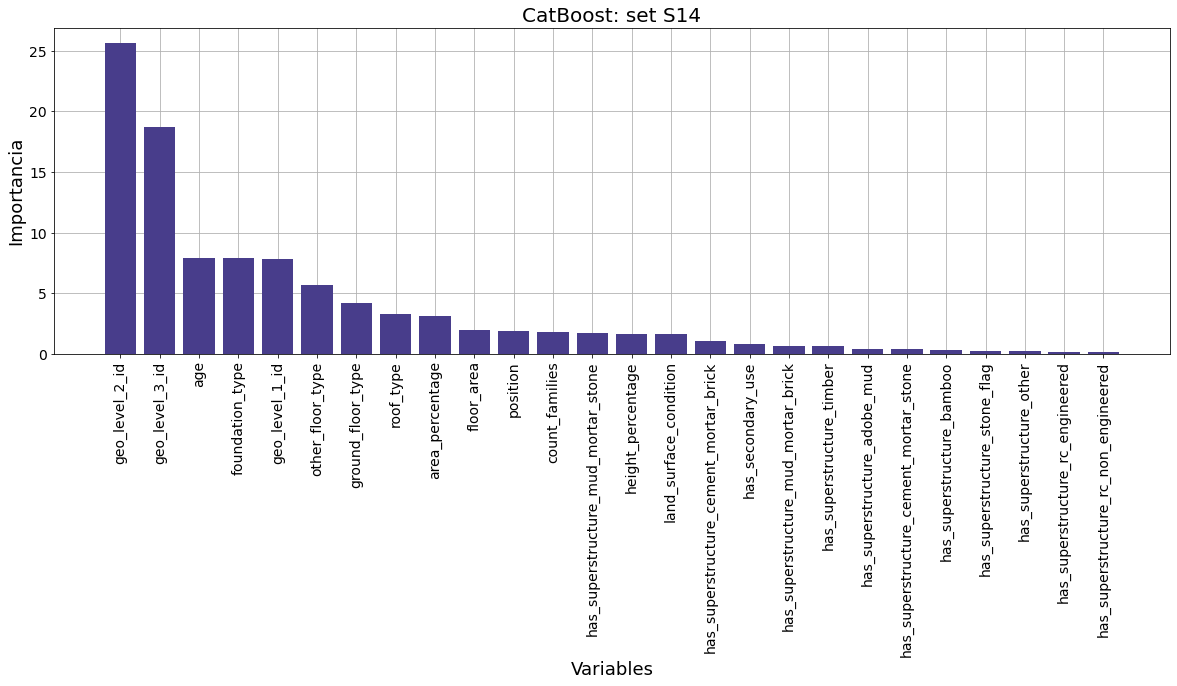

In [63]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s14.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S14',fontsize=20)

## S15

In [64]:
X_train_s15.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 26 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   height_percentage                       195450 non-null  int64   
 5   land_surface_condition                  195450 non-null  category
 6   foundation_type                         195450 non-null  category
 7   roof_type                               195450 non-null  category
 8   ground_floor_type                       195450 non-null  category
 9   other_floor_type                        195450 non-null  category
 10  position                   

In [65]:
model = CatBoostClassifier(cat_features=X_train_s15.select_dtypes('category').columns, random_state=2, logging_level='Silent')
model.fit(X_train_s15,Y_train)

In [66]:
y_pred = model.predict(X_val_s15)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.7468496262528588


[ 7.88897359 25.77293588 18.78934177  7.56823841  1.44932273  1.59001979
  6.82544405  3.87224517  4.2579265   5.11108657  2.47578437  0.3739025
  1.80969903  0.2718622   0.34276814  0.7241699   0.99867254  0.69430808
  0.32285153  0.11640932  0.22733855  0.22061023  1.89131249  1.01395572
  1.69080132  3.70001961]


Text(0.5, 1.0, 'CatBoost: set S15')

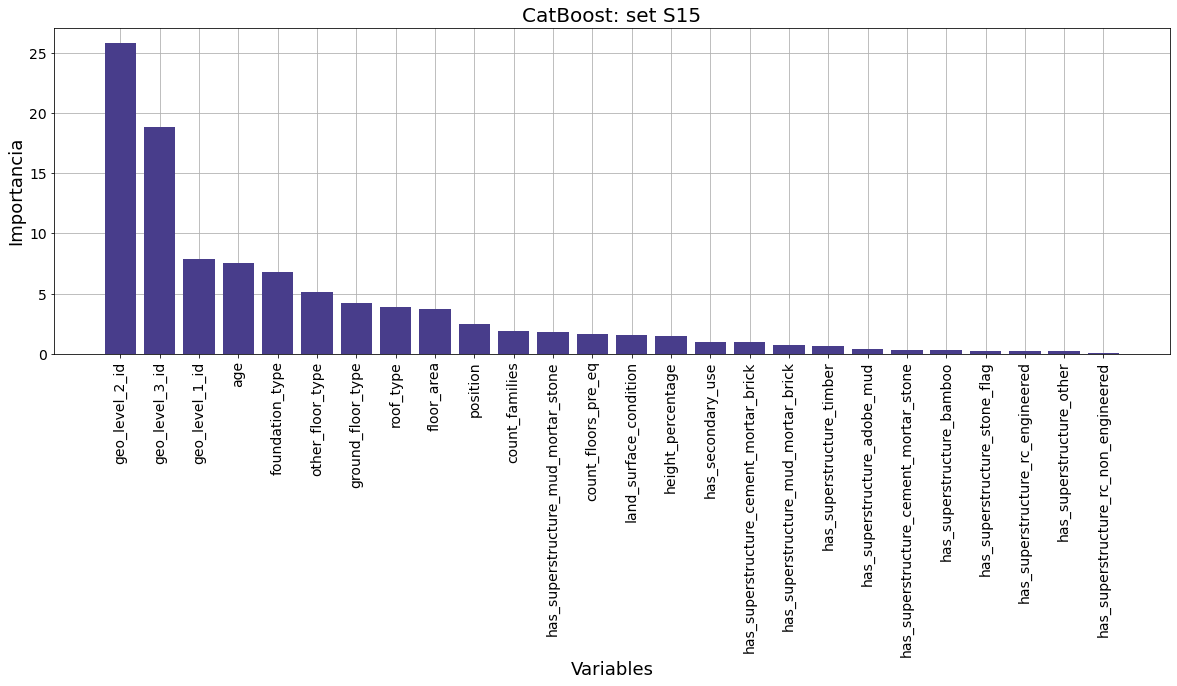

In [67]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s15.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S15',fontsize=20)

## S16

In [68]:
X_train_s16.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 25 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   height_percentage                       195450 non-null  int64   
 5   land_surface_condition                  195450 non-null  category
 6   foundation_type                         195450 non-null  category
 7   roof_type                               195450 non-null  category
 8   ground_floor_type                       195450 non-null  category
 9   other_floor_type                        195450 non-null  category
 10  position                   

In [69]:
model = CatBoostClassifier(cat_features=X_train_s16.select_dtypes('category').columns, random_state=2, logging_level='Silent')
model.fit(X_train_s16,Y_train)

In [70]:
y_pred = model.predict(X_val_s16)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.7473868398029194


[ 8.60119248 24.05248245 20.17161903  7.96018888  2.25084247  1.95034286
  6.63261243  4.33015759  4.44886928  4.78184869  2.13371686  0.43223332
  1.92425988  0.30165614  0.38331994  0.73571716  1.05539003  0.62979
  0.27289785  0.10348694  0.23120727  0.1944893   1.89977483  0.98627137
  3.53563293]


Text(0.5, 1.0, 'CatBoost: set S16')

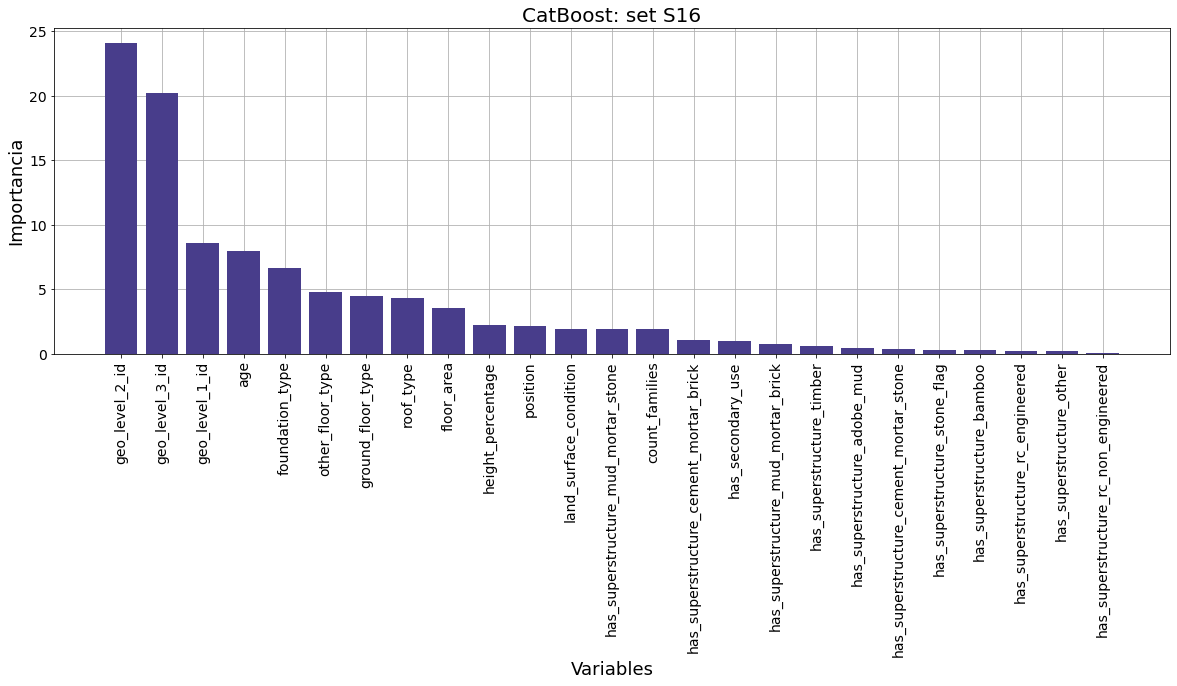

In [71]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s16.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S16',fontsize=20)

## S17

In [72]:
X_train_s17.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 26 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   area_percentage                         195450 non-null  int64   
 5   height_percentage                       195450 non-null  int64   
 6   land_surface_condition                  195450 non-null  category
 7   foundation_type                         195450 non-null  category
 8   roof_type                               195450 non-null  category
 9   ground_floor_type                       195450 non-null  category
 10  other_floor_type           

In [73]:
model = CatBoostClassifier(cat_features=X_train_s17.select_dtypes('category').columns, random_state=2, logging_level='Silent')
model.fit(X_train_s17,Y_train)

In [74]:
y_pred = model.predict(X_val_s17)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.7467575325014197


[ 7.85639138 25.71176438 18.58013375  8.12296926  3.17803595  1.51118387
  1.78573665  7.33809089  3.49922314  4.02030543  5.18392213  2.46118294
  0.39082515  1.75224792  0.31957217  0.34471966  0.72519296  1.13081659
  0.67835004  0.21933911  0.08496042  0.12999133  0.22510841  1.69052614
  0.93278734  2.12662299]


Text(0.5, 1.0, 'CatBoost: set S17')

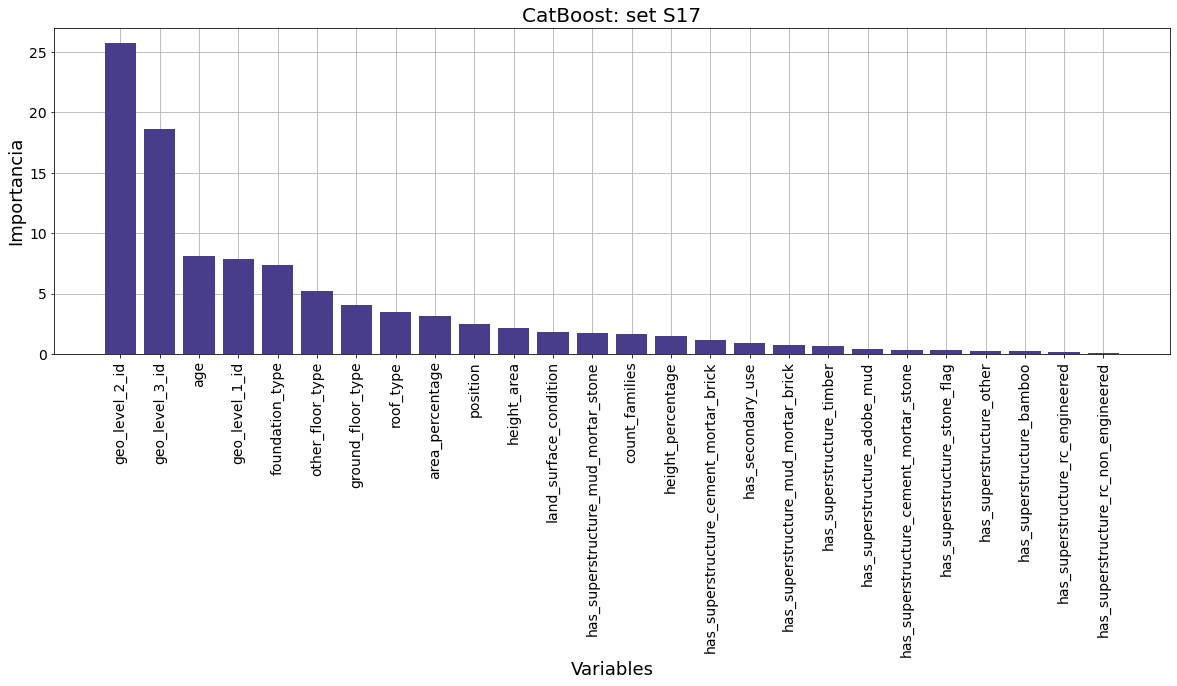

In [75]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s17.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S17',fontsize=20)

## S18

In [76]:
X_train_s18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 25 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   height_percentage                       195450 non-null  int64   
 5   land_surface_condition                  195450 non-null  category
 6   foundation_type                         195450 non-null  category
 7   roof_type                               195450 non-null  category
 8   ground_floor_type                       195450 non-null  category
 9   other_floor_type                        195450 non-null  category
 10  position                   

In [77]:
model = CatBoostClassifier(cat_features=X_train_s18.select_dtypes('category').columns, random_state=2, logging_level='Silent')
model.fit(X_train_s18,Y_train)

In [78]:
y_pred = model.predict(X_val_s18)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.746772881459993


[ 8.12534344 25.35294843 19.26465945  7.71177129  2.60189726  1.73585479
  6.83807123  3.33342624  4.8254641   5.26507496  2.35123492  0.46200378
  1.89892518  0.35716036  0.32356996  0.83006266  1.01950782  0.73275387
  0.28859503  0.1389157   0.11417563  0.19155893  1.72961573  0.96301857
  3.54439067]


Text(0.5, 1.0, 'CatBoost: set S18')

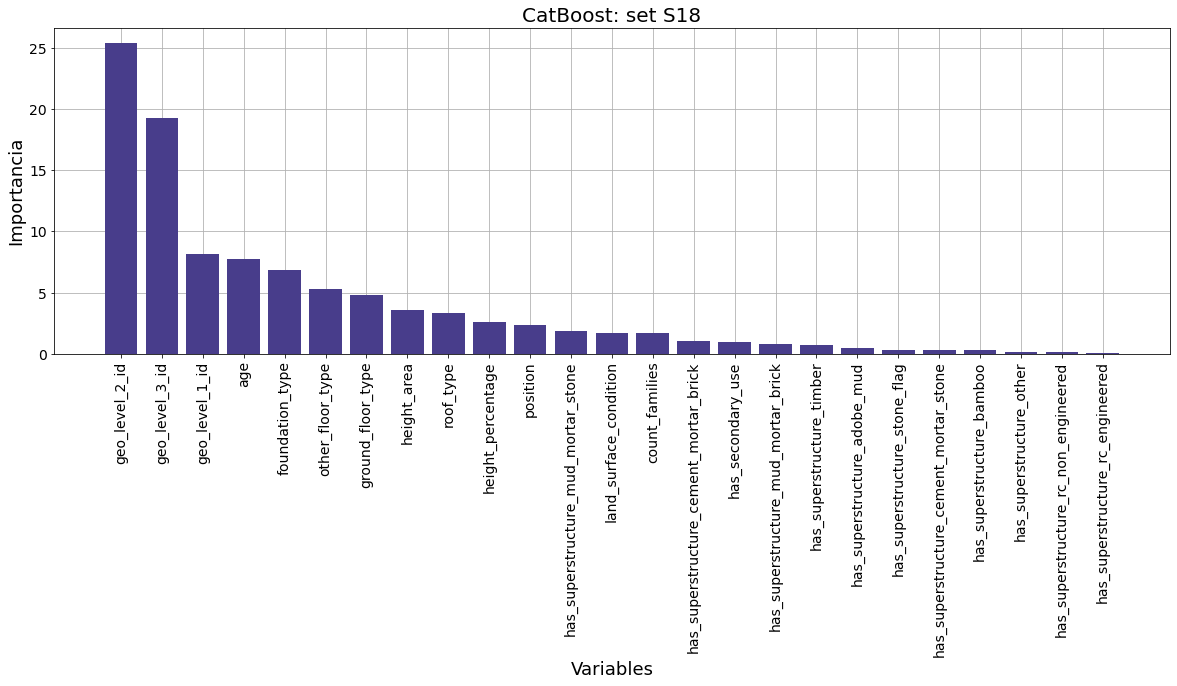

In [79]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s18.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S18',fontsize=20)

## S19

In [80]:
X_train_s19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 25 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   area_percentage                         195450 non-null  int64   
 5   land_surface_condition                  195450 non-null  category
 6   foundation_type                         195450 non-null  category
 7   roof_type                               195450 non-null  category
 8   ground_floor_type                       195450 non-null  category
 9   other_floor_type                        195450 non-null  category
 10  position                   

In [81]:
model = CatBoostClassifier(cat_features=X_train_s19.select_dtypes('category').columns, random_state=2, logging_level='Silent')
model.fit(X_train_s19,Y_train)

In [82]:
y_pred = model.predict(X_val_s19)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.7463277616613713


[ 7.96488577 25.24048169 19.56264952  7.80206822  2.89283897  1.72743097
  7.12925499  3.53849867  4.5878441   5.19245502  2.06897633  0.4053308
  2.31530765  0.35790367  0.39345365  0.74163782  1.11737858  0.7071484
  0.28905903  0.1602088   0.15755634  0.22282437  1.88771613  0.89134935
  2.64574116]


Text(0.5, 1.0, 'CatBoost: set S19')

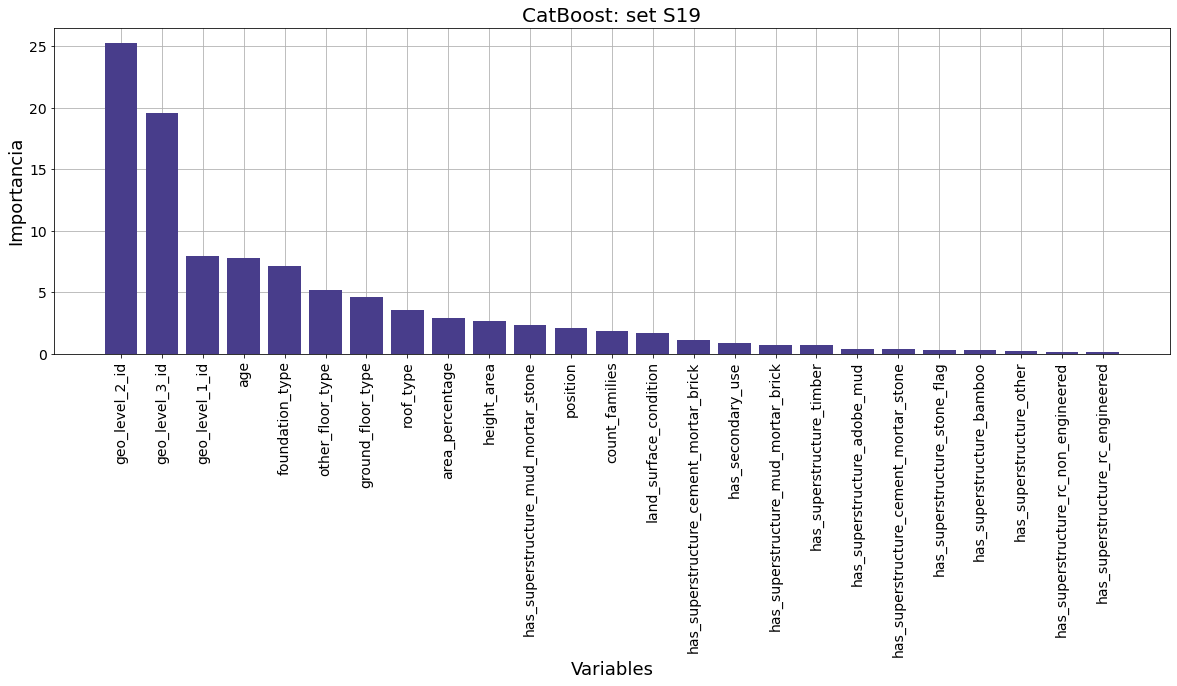

In [83]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s19.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S19',fontsize=20)

## S20

In [84]:
X_train_s20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 24 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   age                                     195450 non-null  int64   
 4   land_surface_condition                  195450 non-null  category
 5   foundation_type                         195450 non-null  category
 6   roof_type                               195450 non-null  category
 7   ground_floor_type                       195450 non-null  category
 8   other_floor_type                        195450 non-null  category
 9   position                                195450 non-null  category
 10  has_superstructure_adobe_mu

In [85]:
model = CatBoostClassifier(cat_features=X_train_s20.select_dtypes('category').columns, random_state=2, logging_level='Silent')
model.fit(X_train_s20,Y_train)

In [86]:
y_pred = model.predict(X_val_s20)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.7465119491642491


[ 8.31625326 25.66204718 19.52255979  7.90987161  1.93284997  7.07088348
  3.62783434  5.04939254  5.09049731  2.49325813  0.44696127  1.82499126
  0.28092956  0.32044632  0.85201698  1.07245404  0.77009418  0.32039923
  0.14792305  0.14936345  0.29344518  1.90977718  0.92675129  4.00899939]


Text(0.5, 1.0, 'CatBoost: set S20')

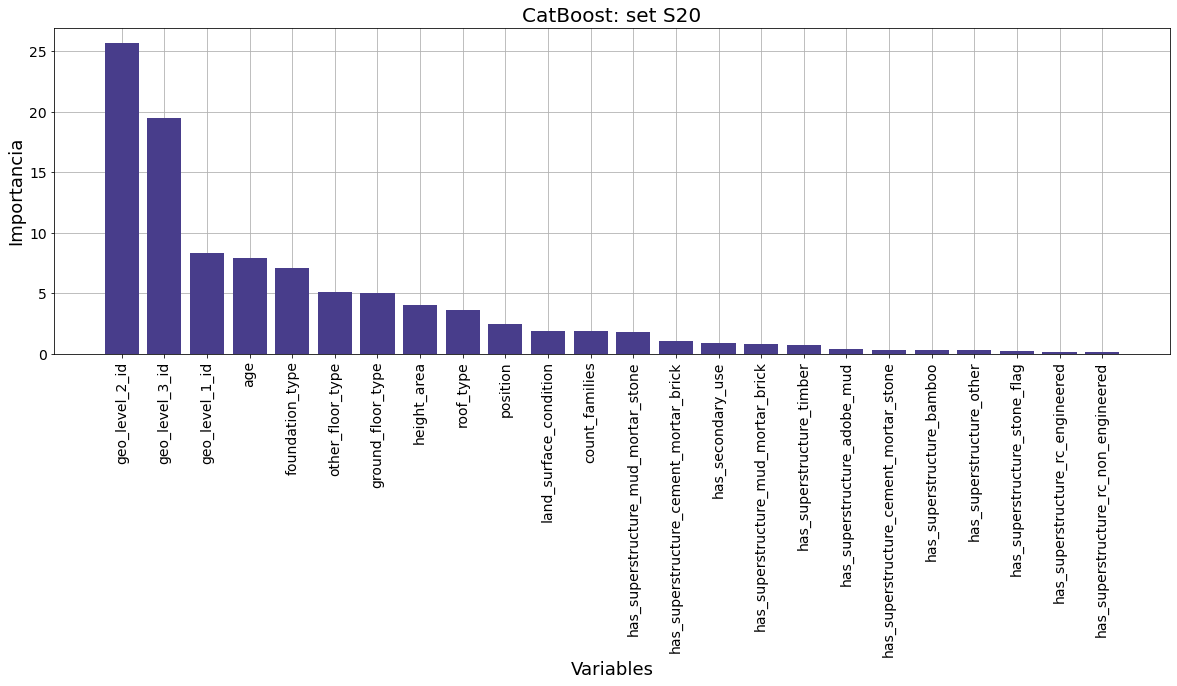

In [87]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s20.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S20',fontsize=20)

## S21

In [88]:
X_train_s21.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   count_floors_pre_eq                     195450 non-null  int64   
 4   age                                     195450 non-null  int64   
 5   area_percentage                         195450 non-null  int64   
 6   height_percentage                       195450 non-null  int64   
 7   land_surface_condition                  195450 non-null  category
 8   foundation_type                         195450 non-null  category
 9   roof_type                               195450 non-null  category
 10  ground_floor_type          

In [89]:
model = CatBoostClassifier(cat_features=X_train_s21.select_dtypes('category').columns, random_state=2, eval_metric='TotalF1:average=Micro', logging_level='Silent')
model.fit(X_train_s21,Y_train)

In [90]:
y_pred = model.predict(X_val_s21)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.7467882304185662


[7.68637928e+00 2.57339713e+01 1.86333453e+01 1.42108512e+00
 7.48953507e+00 2.45228974e+00 1.28419964e+00 1.82810948e+00
 6.97902484e+00 2.93880621e+00 3.54787198e+00 5.49333483e+00
 1.61179857e+00 7.19497281e-01 4.62512112e-01 1.96409771e+00
 2.82812038e-01 3.45409747e-01 6.62601690e-01 1.11453666e+00
 7.25251280e-01 2.50962897e-01 1.21583857e-01 1.81873949e-01
 2.04743765e-01 1.09490981e+00 1.85109980e+00 7.69411271e-01
 2.14411087e-01 8.18364044e-02 7.52764394e-02 1.19980647e-02
 7.95504476e-04 9.58556654e-03 0.00000000e+00 1.24473364e-03
 2.61741547e-02 4.10431277e-02 1.68657978e+00]


Text(0.5, 1.0, 'CatBoost: set S21')

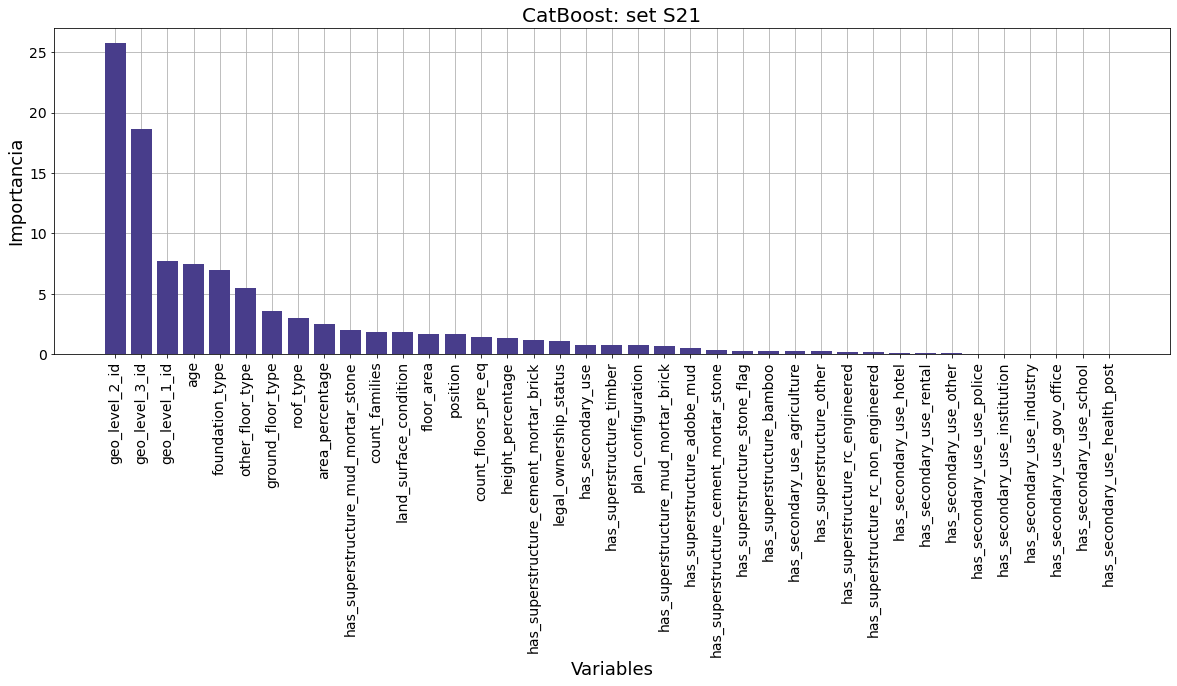

In [91]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s21.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S21',fontsize=20)

In [92]:
model.get_all_params()

{'auto_class_weights': 'None',
 'bagging_temperature': 1,
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': False,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'border_count': 254,
 'class_names': [1, 2, 3],
 'classes_count': 0,
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=2:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'counter_calc_method': 'SkipTest',
 'ctr_leaf_count_limit': 18446744073709551615,
 'ctr_target_border_count': 1,
 'depth': 6,
 'eval_metric': 'TotalF1:average=Micro',
 'feature_border_type': 'GreedyLogSum',
 'fold_permutation_block': 0,
 'grow_policy': 'SymmetricTree',
 'has_time': False,
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.10355400294065475,
 '

## S22

In [93]:
X_train_s22.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 27 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   geo_level_2_id                          195450 non-null  category
 2   geo_level_3_id                          195450 non-null  category
 3   count_floors_pre_eq                     195450 non-null  int64   
 4   age                                     195450 non-null  int64   
 5   area_percentage                         195450 non-null  int64   
 6   height_percentage                       195450 non-null  int64   
 7   land_surface_condition                  195450 non-null  category
 8   foundation_type                         195450 non-null  category
 9   roof_type                               195450 non-null  category
 10  ground_floor_type          

In [94]:
model = CatBoostClassifier(cat_features=X_train_s22.select_dtypes('category').columns, random_state=2, eval_metric='TotalF1:average=Micro', logging_level='Silent')
model.fit(X_train_s22,Y_train)

In [95]:
y_pred = model.predict(X_val_s22)
f1_val=f1_score(Y_val, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.7466347408328345


[ 8.23638443 24.22831949 19.52963923  1.04244019  7.69970421  2.92132198
  1.80719418  1.4220011   7.77517928  3.91919022  4.05112655  5.01588911
  2.31279011  0.83149448  0.39028835  1.97028997  0.36603427  0.33476486
  0.70418549  1.12924319  0.67723606  0.28712702  0.14427431  0.16947073
  0.23091794  1.70078495  1.1027083 ]


Text(0.5, 1.0, 'CatBoost: set S22')

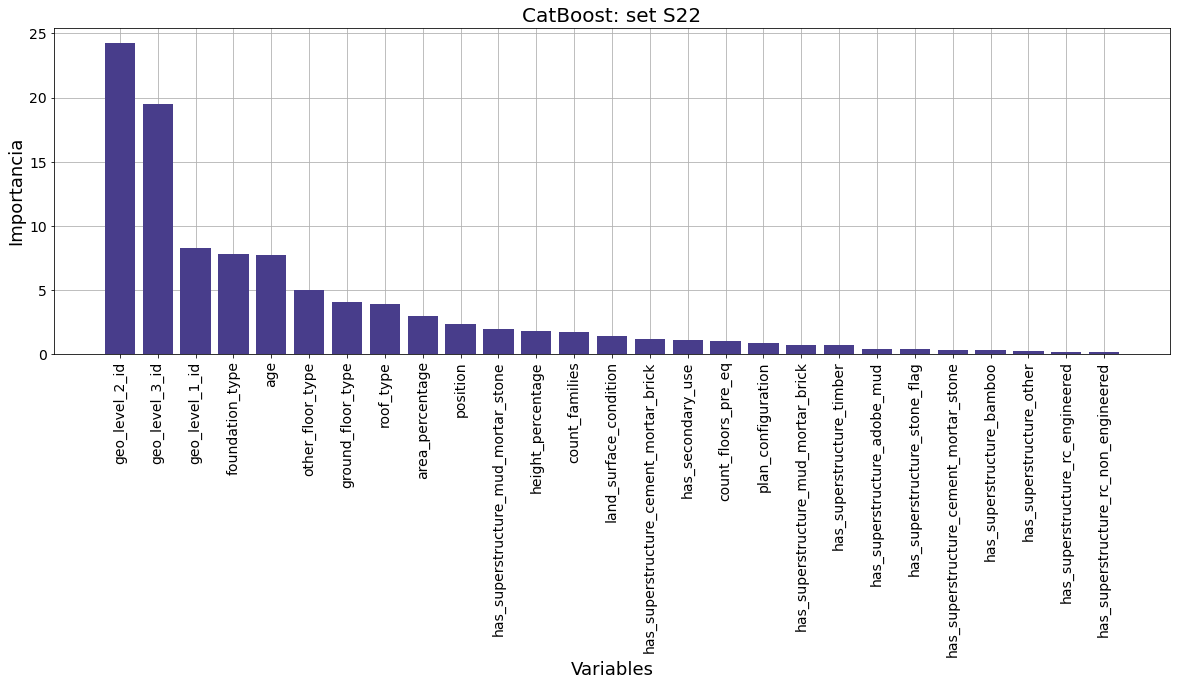

In [96]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s22.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S22',fontsize=20)

In [97]:
model.get_all_params()

{'auto_class_weights': 'None',
 'bagging_temperature': 1,
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': False,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'border_count': 254,
 'class_names': [1, 2, 3],
 'classes_count': 0,
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=2:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'counter_calc_method': 'SkipTest',
 'ctr_leaf_count_limit': 18446744073709551615,
 'ctr_target_border_count': 1,
 'depth': 6,
 'eval_metric': 'TotalF1:average=Micro',
 'feature_border_type': 'GreedyLogSum',
 'fold_permutation_block': 0,
 'grow_policy': 'SymmetricTree',
 'has_time': False,
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.10355400294065475,
 '